# Using a Genetic Algorithm to recreate an image

- **Goal**: Using a GA, we'll try to regenerate an image using a triangles overlain over each other.
- **Prequisites**: A small JPG (the extension and type is very important!) image (~ 100 x 100 to 200 x 200 pixels) 
- **Reference**: Modified from: https://scturtle.me/posts/2014-04-18-ga.html

# Imports

In [30]:
from deap import base, creator, tools, algorithms
from random import randint, random, gauss
from PIL import Image, ImageDraw
from functools import partial
from math import sqrt
from datetime import datetime
import numpy
import multiprocessing
import matplotlib.pyplot as plt

Load the file and define some useful constants

In [39]:
# Now load the image, and set some constants:
filename = 'myimage.jpg'  # set your image name here
IMG = Image.open(filename)
WIDTH, HEIGHT = IMG.size
NUMBER_OF_TRIANGLES = 50
POPULATION = 40
NGEN = 100
POLY = 3

Now setup some convenience functions:

In [32]:
def gen_one_triangle():
    return (tuple([(randint(0, WIDTH), randint(0, HEIGHT)) for i in xrange(POLY)]),
            randint(0,255), randint(0,255), randint(0,255), randint(0,30))


def triangles_to_image(triangles):
    im = Image.new('RGB', (WIDTH, HEIGHT), (255, 255, 255))
    for tri in triangles:
        mask = Image.new('RGBA', (WIDTH, HEIGHT))
        draw = ImageDraw.Draw(mask)
        draw.polygon(tri[0], fill=tri[1:])
        im.paste(mask, mask=mask)
        del mask, draw
    return im

As before, we define our evaluation function:

In [33]:
def evaluate(im1, t2):
    im2 = triangles_to_image(t2)
    pix1, pix2 = im1.load(), im2.load()
    ans = 0
    for i in xrange(HEIGHT):
        for j in xrange(WIDTH):
            a1, a2, a3 = pix1[i, j]
            b1, b2, b3 = pix2[i, j]
            ans += (a1 - b1) ** 2 + (a2 - b2) ** 2 + (a3 - b3) ** 2
    return 1 - (1. * sqrt(ans) / sqrt(WIDTH * HEIGHT * 3 * 255 * 255)),

Similarly, we configure our mutation function:

In [34]:
def mutate(triangles):
    e0 = evaluate(IMG, triangles)
    for i in xrange(10):
        tid = randint(0, NUMBER_OF_TRIANGLES - 1)
        oldt = triangles[tid]

        t = list(oldt)
        p = randint(0, 2 * POLY + 4 - 1)
        if p < 2 * POLY:
            points = list(t[0])
            pnt = list(points[p / 2])
            pnt[p % 2] = randint(0, WIDTH)
            points[p / 2] = tuple(pnt)
            t[0] = tuple(points)
        else:
            p -= 2 * POLY - 1
            t[p] = randint(0, 255)

        triangles[tid] = tuple(t)
        if evaluate(IMG, triangles) > e0:
            break
        else:
            triangles[tid] = oldt
    return triangles,  # note the trailing comma here!

Finally, we setup DEAP

In [35]:
creator.create("Fitness", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.Fitness)

toolbox = base.Toolbox()

# multiprocessing
pool = multiprocessing.Pool(processes=16)
toolbox.register("map", pool.map)

toolbox.register("attr", gen_one_triangle)
toolbox.register("individual", 
                 tools.initRepeat, 
                 creator.Individual, 
                 toolbox.attr, 
                 NUMBER_OF_TRIANGLES)

toolbox.register("population", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individual)

toolbox.register("evaluate", partial(evaluate, IMG))
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

Now we attempt evolve the image. Note that this can take a long time (~ hours) if a large image is used!

In [42]:
start = datetime.now()
verbose = False
pop = toolbox.population(n=POPULATION)
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", numpy.min)
stats.register("max", numpy.max)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)

try:
    pop, log = algorithms.eaSimple(pop, 
                                   toolbox, 
                                   cxpb=0.5, 
                                   mutpb=0.1, 
                                   ngen=NGEN, 
                                   stats=stats,
                                   halloffame=hof, 
                                   verbose=verbose)
finally:
    if len(hof) > 0:
        # Save the results
        open('result.txt', 'w').write(repr(hof[0]))
        triangles_to_image(hof[0]).save('result.png')
        
print datetime.now() - start  # tell us how much time has elapsed

0:00:37.032754


Compare the results:

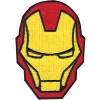

In [37]:
import IPython.display as display
display.Image(filename='myimage.jpg') # original

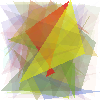

In [38]:
display.Image(filename='result.png')

# Activity 1: What happens when we use a different polygon?

# Activity 2: What happens when we vary the population and the number of polygons?